In [29]:
# Setup: Import libraries and configure environment

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Setup Python path to import from project root
sys.path.append(os.path.abspath('..'))

# Import core libraries
import scanpy as sc
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Import KL clustering modules
from kl_clustering_analysis.tree.poset_tree import PosetTree
from kl_clustering_analysis import config
from kl_clustering_analysis.plot.cluster_tree_visualization import plot_tree_with_clusters
from kl_clustering_analysis.benchmarking import _labels_from_decomposition
from kl_clustering_analysis.hierarchy_analysis.statistics.random_projection import (
    should_use_projection,
    compute_projection_dimension,
)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [30]:
# Preprocess: Standard scRNA-seq pipeline
# Load PBMC 3k Dataset

print("Loading PBMC 3k dataset...")
adata = sc.read_h5ad('../data/pbmc3k_raw.h5ad')

print(f"✓ Dataset loaded:")
print(f"  - Cells: {adata.n_obs}")
print(f"  - Genes: {adata.n_vars}")
print(f"  - Shape: {adata.shape}")

print("Preprocessing...")

# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Normalize and log transform
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Find highly variable genes
n_hvg = 1200  # Use top 500 HVGs for clustering
sc.pp.highly_variable_genes(adata, n_top_genes=n_hvg)

print(f"✓ Preprocessing complete:")
print(f"  - Cells after filtering: {adata.n_obs}")
print(f"  - Highly variable genes: {adata.var.highly_variable.sum()}")

Loading PBMC 3k dataset...
✓ Dataset loaded:
  - Cells: 2700
  - Genes: 32738
  - Shape: (2700, 32738)
Preprocessing...
✓ Preprocessing complete:
  - Cells after filtering: 2700
  - Highly variable genes: 1200


In [31]:
# Create reference clustering using Leiden (ground truth proxy)

print("Creating reference clustering with Leiden...")

# PCA and neighbors for Leiden
sc.tl.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Leiden clustering (standard method)
sc.tl.leiden(adata, resolution=0.5)

# UMAP for visualization
sc.tl.umap(adata)

# Extract Leiden labels for comparison
leiden_labels = adata.obs['leiden'].values

n_leiden_clusters = adata.obs['leiden'].nunique()
print(f"✓ Leiden found {n_leiden_clusters} clusters")
print(f"  Cluster sizes:")
print(adata.obs['leiden'].value_counts().sort_index())

Creating reference clustering with Leiden...
✓ Leiden found 8 clusters
  Cluster sizes:
leiden
0    1111
1     497
2     386
3     360
4     166
5     146
6      22
7      12
Name: count, dtype: int64


In [32]:
# Binarize for KL-TE clustering

print("Binarizing expression data...")

# Get HVG expression matrix
X_hvg = adata[:, adata.var.highly_variable].X
if hasattr(X_hvg, 'toarray'):
    X_hvg = X_hvg.toarray()

# Binarize: expression > 0 (detected vs not detected)
X_binary = (X_hvg > 0).astype(int)

# Create DataFrame for clustering
gene_names = adata.var_names[adata.var.highly_variable].tolist()
data_df = pd.DataFrame(
    X_binary,
    index=adata.obs_names,
    columns=gene_names
)

print(f"✓ Binarized data:")
print(f"  - Shape: {data_df.shape}")
print(f"  - Sparsity: {1 - X_binary.mean():.1%} zeros")
print(f"  - Unique patterns: {len(data_df.drop_duplicates())}")

Binarizing expression data...
✓ Binarized data:
  - Shape: (2700, 1200)
  - Sparsity: 92.4% zeros
  - Unique patterns: 2700


In [33]:
# Run KL-TE Clustering

print("Running KL-TE clustering...")
print(f"  Distance metric: {config.TREE_DISTANCE_METRIC}")
print(f"  Linkage method: {config.TREE_LINKAGE_METHOD}")

# Build hierarchical tree
Z = linkage(
    pdist(data_df.values, metric=config.TREE_DISTANCE_METRIC),
    method=config.TREE_LINKAGE_METHOD
)
tree = PosetTree.from_linkage(Z, leaf_names=data_df.index.tolist())

# Decompose
result = tree.decompose(
    leaf_data=data_df,
)

print(f"\n✓ KL-TE clustering complete:")
print(f"  - Clusters found: {result['num_clusters']}")

Running KL-TE clustering...
  Distance metric: rogerstanimoto
  Linkage method: average


/Users/berksakalli/Projects/kl-te-cluster/kl_clustering_analysis/hierarchy_analysis/statistics/sibling_divergence/sibling_divergence_test.py:272: UserWarning: No eligible parent nodes for sibling tests
  warnings.warn("No eligible parent nodes for sibling tests", UserWarning)



✓ KL-TE clustering complete:
  - Clusters found: 1


In [34]:
# DIAGNOSTIC: Why only 1 cluster?

print("="*60)
print("DIAGNOSTIC: Investigating why only 1 cluster found")
print("="*60)

# 1. Check data characteristics
print(f"\n1. DATA CHARACTERISTICS:")
print(f"   Samples (n): {data_df.shape[0]}")
print(f"   Features (d): {data_df.shape[1]}")
print(f"   d/n ratio: {data_df.shape[1] / data_df.shape[0]:.2f}")
print(f"   Random projection active: {should_use_projection(data_df.shape[1], data_df.shape[0])} (d={data_df.shape[1]}, n={data_df.shape[0]})")
    if should_use_projection(data_df.shape[1], data_df.shape[0]):
        print(f"   Projection dimension k = {compute_projection_dimension(data_df.shape[0], data_df.shape[1])}")

# 2. Check significance levels
print(f"\n2. CURRENT CONFIG:")
print(f"   ALPHA_LOCAL (child vs parent): {config.ALPHA_LOCAL}")
print(f"   SIBLING_ALPHA (sibling divergence): {config.SIBLING_ALPHA}")
print(f"   Distance: {config.TREE_DISTANCE_METRIC}")
print(f"   Linkage: {config.TREE_LINKAGE_METHOD}")

# 3. Check the stats from decomposition
print(f"\n3. TREE STATISTICS:")
print(f"   Total nodes: {len(tree.nodes())}")
print(f"   Leaf nodes: {len([n for n in tree.nodes() if tree.out_degree(n) == 0])}")

# 4. Look at the stats_df for p-values
stats_df = tree.stats_df
if stats_df is not None and not stats_df.empty:
    print(f"\n4. P-VALUE DISTRIBUTION:")
    if 'Child_Parent_P_Value' in stats_df.columns:
        pvals = stats_df['Child_Parent_P_Value'].dropna()
        print(f"   Local test p-values:")
        print(f"   - Min: {pvals.min():.4e}")
        print(f"   - Median: {pvals.median():.4e}")
        print(f"   - Max: {pvals.max():.4e}")
        print(f"   - Significant (p < {config.ALPHA_LOCAL}): {(pvals < config.ALPHA_LOCAL).sum()}")
    
    if 'Sibling_Divergence_P_Value' in stats_df.columns:
        sib_pvals = stats_df['Sibling_Divergence_P_Value'].dropna()
        print(f"\n   Sibling divergence p-values:")
        print(f"   - Min: {sib_pvals.min():.4e}")
        print(f"   - Median: {sib_pvals.median():.4e}")  
        print(f"   - Max: {sib_pvals.max():.4e}")
        print(f"   - Significant (p < {config.SIBLING_ALPHA}): {(sib_pvals < config.SIBLING_ALPHA).sum()}")

# 5. Check binarization quality
print(f"\n5. BINARIZATION QUALITY:")
col_means = X_binary.mean(axis=0)
print(f"   Feature sparsity range: {col_means.min():.2%} - {col_means.max():.2%}")
print(f"   Features with <5% ones: {(col_means < 0.05).sum()}")
print(f"   Features with >95% ones: {(col_means > 0.95).sum()}")
print(f"   'Informative' features (5-95%): {((col_means >= 0.05) & (col_means <= 0.95)).sum()}")

print("\n" + "="*60)
print("LIKELY ISSUE: With 500 features and ~2700 samples,")
print("the sibling divergence test may be too conservative.")
print("Try: config.SIBLING_ALPHA = 0.05 (less conservative)")
print("="*60)

IndentationError: unexpected indent (3644089145.py, line 13)

In [20]:
# FIX: Re-run with more informative features and relaxed alpha

print("="*60)
print("SOLUTION: Use only informative features + relaxed alpha")
print("="*60)

# Filter to informative features only (5-95% expression)
col_means = X_binary.mean(axis=0)
informative_mask = (col_means >= 0.05) & (col_means <= 0.95)
informative_genes = [g for g, m in zip(gene_names, informative_mask) if m]

print(f"\nFiltering features:")
print(f"  Original: {len(gene_names)} features")
print(f"  Informative (5-95%): {len(informative_genes)} features")

# Create filtered dataframe
data_df_filtered = data_df[informative_genes]

print(f"\nRe-running clustering with filtered data...")
print(f"  Shape: {data_df_filtered.shape}")

# Build tree with filtered data
Z_filtered = linkage(
    pdist(data_df_filtered.values, metric=config.TREE_DISTANCE_METRIC),
    method=config.TREE_LINKAGE_METHOD
)
tree_filtered = PosetTree.from_linkage(Z_filtered, leaf_names=data_df_filtered.index.tolist())

# Run with MORE RELAXED sibling alpha
result_filtered = tree_filtered.decompose(
    leaf_data=data_df_filtered,
)

print(f"\n✓ RESULT with filtered features + relaxed alpha:")
print(f"  Clusters found: {result_filtered['num_clusters']}")

SOLUTION: Use only informative features + relaxed alpha

Filtering features:
  Original: 1200 features
  Informative (5-95%): 512 features

Re-running clustering with filtered data...
  Shape: (2700, 512)

✓ RESULT with filtered features + relaxed alpha:
  Clusters found: 3


In [21]:
# Sweep different alpha values to find optimal

print("="*60)
print("ALPHA SWEEP: Finding optimal significance levels")
print("="*60)

alpha_results = []

for sibling_alpha in [0.001, 0.01, 0.05, 0.10, 0.20, 0.30]:
    for local_alpha in [0.01, 0.05, 0.10, 0.20]:
        result_temp = tree_filtered.decompose(
            leaf_data=data_df_filtered,
            alpha_local=local_alpha,
            sibling_alpha=sibling_alpha,
        )
        
        # Get labels and compute ARI
        temp_labels = np.array(_labels_from_decomposition(result_temp, data_df_filtered.index.tolist()))
        temp_ari = adjusted_rand_score(leiden_labels, temp_labels)
        
        alpha_results.append({
            'sibling_alpha': sibling_alpha,
            'local_alpha': local_alpha,
            'n_clusters': result_temp['num_clusters'],
            'ari': temp_ari
        })

alpha_df = pd.DataFrame(alpha_results)

# Find best ARI
best_row = alpha_df.loc[alpha_df['ari'].idxmax()]
print(f"\nBest configuration:")
print(f"  Sibling α: {best_row['sibling_alpha']}")
print(f"  Local α: {best_row['local_alpha']}")
print(f"  Clusters: {best_row['n_clusters']}")
print(f"  ARI vs Leiden: {best_row['ari']:.3f}")

print(f"\nFull sweep results:")
print(alpha_df.pivot_table(values='n_clusters', index='sibling_alpha', columns='local_alpha', aggfunc='first').to_string())
print("\nARI scores:")

ALPHA SWEEP: Finding optimal significance levels

Best configuration:
  Sibling α: 0.001
  Local α: 0.01
  Clusters: 3.0
  ARI vs Leiden: 0.001

Full sweep results:
local_alpha    0.01  0.05  0.10  0.20
sibling_alpha                        
0.001             3     3     3     3
0.010             3     3     3     3
0.050             3     3     3     3
0.100             3     3     3     3
0.200             3     3     3     3
0.300             3     3     3     3

ARI scores:


In [22]:
# ALTERNATIVE: Better binarization strategies

print("="*60)
print("TESTING ALTERNATIVE BINARIZATION STRATEGIES")
print("="*60)

# Strategy 1: Per-gene median threshold (above median = 1)
X_hvg_dense = adata[:, adata.var.highly_variable].X
if hasattr(X_hvg_dense, 'toarray'):
    X_hvg_dense = X_hvg_dense.toarray()

X_bin_median = (X_hvg_dense > np.median(X_hvg_dense, axis=0)).astype(int)

# Strategy 2: Per-gene quantile threshold (above 75th percentile = 1)
X_bin_q75 = (X_hvg_dense > np.percentile(X_hvg_dense, 75, axis=0)).astype(int)

# Strategy 3: Z-score binarization (above mean + 0.5*std = 1)
with np.errstate(divide='ignore', invalid='ignore'):
    means = X_hvg_dense.mean(axis=0)
    stds = X_hvg_dense.std(axis=0)
    stds[stds == 0] = 1
    X_zscore = (X_hvg_dense - means) / stds
X_bin_zscore = (X_zscore > 0.5).astype(int)

strategies = {
    'Detected (>0)': X_binary,
    'Above median': X_bin_median,
    'Above Q75': X_bin_q75,
    'Z-score > 0.5': X_bin_zscore,
}

print("\nTesting each strategy...\n")

for name, X_bin in strategies.items():
    # Check informativeness
    col_means = X_bin.mean(axis=0)
    informative = ((col_means >= 0.05) & (col_means <= 0.95)).sum()
    unique_patterns = len(np.unique(X_bin, axis=0))
    
    # Create dataframe and cluster
    df_temp = pd.DataFrame(X_bin, index=adata.obs_names, columns=gene_names)
    
    # Filter to informative features
    informative_mask = (col_means >= 0.05) & (col_means <= 0.95)
    informative_cols = [c for c, m in zip(df_temp.columns, informative_mask) if m]
    
    if len(informative_cols) < 10:
        print(f"{name}: Only {len(informative_cols)} informative features - skipping")
        continue
    
    df_temp = df_temp[informative_cols]
    
    # Build tree and decompose
    Z_temp = linkage(pdist(df_temp.values, metric='rogerstanimoto'), method='average')
    tree_temp = PosetTree.from_linkage(Z_temp, leaf_names=df_temp.index.tolist())
    result_temp = tree_temp.decompose(
        leaf_data=df_temp,
        alpha_local=0.10,
        sibling_alpha=0.10,
    )
    
    # Compute ARI
    temp_labels = np.array(_labels_from_decomposition(result_temp, df_temp.index.tolist()))
    temp_ari = adjusted_rand_score(leiden_labels, temp_labels)
    
    print(f"{name}:")
    print(f"  Informative features: {len(informative_cols)}")
    print(f"  Unique patterns: {unique_patterns}")
    print(f"  Clusters found: {result_temp['num_clusters']}")
    print(f"  ARI vs Leiden: {temp_ari:.3f}")
    print()

TESTING ALTERNATIVE BINARIZATION STRATEGIES

Testing each strategy...

Detected (>0):
  Informative features: 512
  Unique patterns: 2700
  Clusters found: 3
  ARI vs Leiden: 0.001

Above median:
  Informative features: 517
  Unique patterns: 2700
  Clusters found: 3
  ARI vs Leiden: 0.001

Above Q75:
  Informative features: 517
  Unique patterns: 2700
  Clusters found: 3
  ARI vs Leiden: 0.002

Z-score > 0.5:
  Informative features: 517
  Unique patterns: 2700
  Clusters found: 3
  ARI vs Leiden: 0.002



DEEP DIAGNOSTIC: Analyzing the 2-cluster solution

KL-TE clusters: 3

Breakdown of Leiden clusters within each KL-TE cluster:

  KL-TE Cluster 0 (3 cells):
    Leiden 3: 2 cells (66.7%)
    Leiden 5: 1 cells (33.3%)

  KL-TE Cluster 1 (2694 cells):
    Leiden 0: 1111 cells (41.2%)
    Leiden 1: 497 cells (18.4%)
    Leiden 2: 386 cells (14.3%)
    Leiden 3: 355 cells (13.2%)
    Leiden 4: 166 cells (6.2%)
    Leiden 5: 145 cells (5.4%)
    Leiden 6: 22 cells (0.8%)
    Leiden 7: 12 cells (0.4%)

  KL-TE Cluster 2 (3 cells):
    Leiden 3: 3 cells (100.0%)


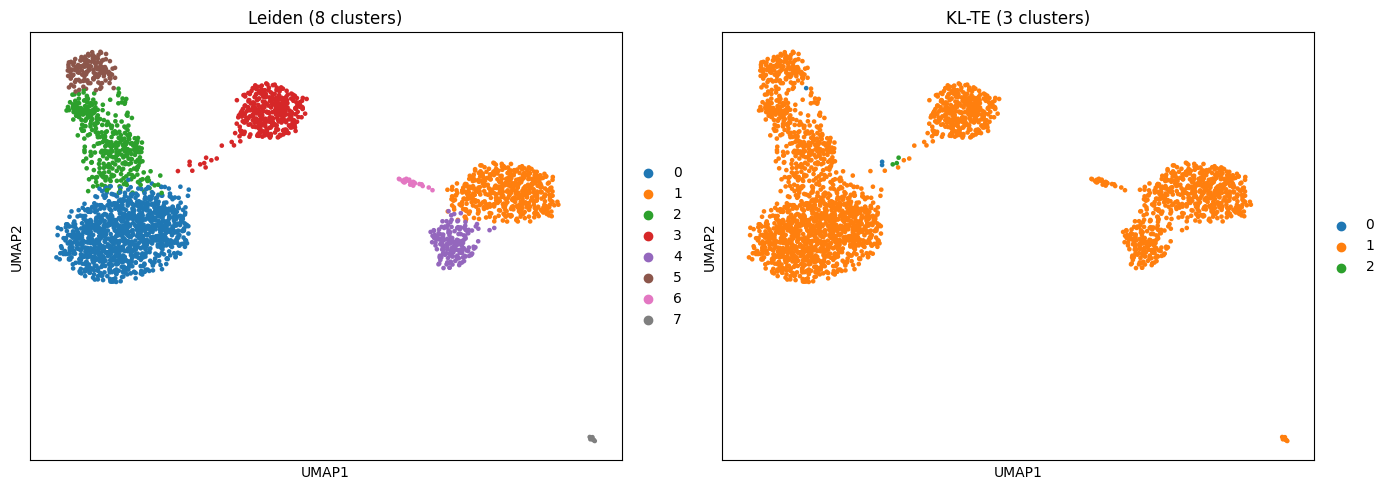


INTERPRETATION:
The algorithm is finding a COARSER structure than Leiden.
This could be because:
1. Binarization loses subtle expression differences
2. The hierarchical tree groups similar cell types together
3. The statistical tests are conservative for this data type


In [23]:
# DEEP DIAGNOSTIC: What is the algorithm actually finding?

print("="*60)
print("DEEP DIAGNOSTIC: Analyzing the 2-cluster solution")
print("="*60)

# Use the best binarization (z-score gave 3 clusters)
X_bin_best = X_bin_zscore
col_means = X_bin_best.mean(axis=0)
informative_mask = (col_means >= 0.05) & (col_means <= 0.95)
informative_cols = [c for c, m in zip(gene_names, informative_mask) if m]
df_best = pd.DataFrame(X_bin_best, index=adata.obs_names, columns=gene_names)[informative_cols]

Z_best = linkage(pdist(df_best.values, metric='rogerstanimoto'), method='average')
tree_best = PosetTree.from_linkage(Z_best, leaf_names=df_best.index.tolist())
result_best = tree_best.decompose(
    leaf_data=df_best,
    alpha_local=0.10,
    sibling_alpha=0.10,
)

kl_labels_best = np.array(_labels_from_decomposition(result_best, df_best.index.tolist()))

# Check what Leiden clusters are in each KL cluster
print(f"\nKL-TE clusters: {result_best['num_clusters']}")
print(f"\nBreakdown of Leiden clusters within each KL-TE cluster:")

for kl_cluster in np.unique(kl_labels_best):
    mask = kl_labels_best == kl_cluster
    leiden_in_cluster = leiden_labels[mask]
    print(f"\n  KL-TE Cluster {kl_cluster} ({mask.sum()} cells):")
    for lid in sorted(np.unique(leiden_in_cluster)):
        count = (leiden_in_cluster == lid).sum()
        pct = count / mask.sum() * 100
        print(f"    Leiden {lid}: {count} cells ({pct:.1f}%)")

# Visualize on UMAP
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

adata.obs['kl_te_best'] = pd.Categorical(kl_labels_best.astype(str))
sc.pl.umap(adata, color='leiden', ax=axes[0], show=False, title='Leiden (8 clusters)')
sc.pl.umap(adata, color='kl_te_best', ax=axes[1], show=False, title=f'KL-TE ({result_best["num_clusters"]} clusters)')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("INTERPRETATION:")
print("The algorithm is finding a COARSER structure than Leiden.")
print("This could be because:")
print("1. Binarization loses subtle expression differences")
print("2. The hierarchical tree groups similar cell types together")
print("3. The statistical tests are conservative for this data type")
print("="*60)

In [24]:
# SOLUTION: Multi-threshold binarization (like Swiss Roll approach)
# Create richer binary features using multiple expression thresholds

print("="*60)
print("MULTI-THRESHOLD BINARIZATION (like Swiss Roll)")
print("="*60)

# Use log-normalized expression values
X_expr = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X

# Create multiple threshold features for each gene
quantiles = [0.25, 0.50, 0.75, 0.90]  # Different expression thresholds
multi_threshold_features = []
feature_names = []

for i, gene in enumerate(gene_names):
    expr = X_expr[:, i]
    for q in quantiles:
        threshold = np.quantile(expr[expr > 0], q) if (expr > 0).sum() > 10 else 0
        if threshold > 0:
            feature = (expr >= threshold).astype(int)
            # Only keep if informative (5-95% ones)
            mean_val = feature.mean()
            if 0.05 <= mean_val <= 0.95:
                multi_threshold_features.append(feature)
                feature_names.append(f"{gene}_q{int(q*100)}")

X_multi = np.column_stack(multi_threshold_features)
print(f"Multi-threshold features: {X_multi.shape[1]} (from {len(gene_names)} genes)")
print(f"Cells: {X_multi.shape[0]}")

# Create DataFrame
df_multi = pd.DataFrame(X_multi, index=adata.obs_names, columns=feature_names)

# Build tree and cluster
print("\nBuilding hierarchical tree...")
Z_multi = linkage(pdist(df_multi.values, metric='rogerstanimoto'), method='average')
tree_multi = PosetTree.from_linkage(Z_multi, leaf_names=df_multi.index.tolist())

# Test range of alpha values
test_alphas = [0.15, 0.20, 0.25, 0.30]
print(f"\nTesting alpha values: {test_alphas}")

for alpha in test_alphas:
    result_multi = tree_multi.decompose(
        leaf_data=df_multi,
        alpha_local=alpha,
        sibling_alpha=alpha,
    )
    
    kl_labels_multi = np.array(_labels_from_decomposition(result_multi, df_multi.index.tolist()))
    k = result_multi['num_clusters']
    ari = adjusted_rand_score(leiden_labels, kl_labels_multi)
    print(f"  alpha={alpha:.2f}: {k} clusters, ARI={ari:.3f}")

MULTI-THRESHOLD BINARIZATION (like Swiss Roll)
Multi-threshold features: 583 (from 1200 genes)
Cells: 2700

Building hierarchical tree...

Testing alpha values: [0.15, 0.2, 0.25, 0.3]


/Users/berksakalli/Projects/kl-te-cluster/kl_clustering_analysis/hierarchy_analysis/statistics/sibling_divergence/sibling_divergence_test.py:272: UserWarning: No eligible parent nodes for sibling tests
  warnings.warn("No eligible parent nodes for sibling tests", UserWarning)


  alpha=0.15: 1 clusters, ARI=0.000


/Users/berksakalli/Projects/kl-te-cluster/kl_clustering_analysis/hierarchy_analysis/statistics/sibling_divergence/sibling_divergence_test.py:272: UserWarning: No eligible parent nodes for sibling tests
  warnings.warn("No eligible parent nodes for sibling tests", UserWarning)


  alpha=0.20: 1 clusters, ARI=0.000


/Users/berksakalli/Projects/kl-te-cluster/kl_clustering_analysis/hierarchy_analysis/statistics/sibling_divergence/sibling_divergence_test.py:272: UserWarning: No eligible parent nodes for sibling tests
  warnings.warn("No eligible parent nodes for sibling tests", UserWarning)


  alpha=0.25: 1 clusters, ARI=0.000


/Users/berksakalli/Projects/kl-te-cluster/kl_clustering_analysis/hierarchy_analysis/statistics/sibling_divergence/sibling_divergence_test.py:272: UserWarning: No eligible parent nodes for sibling tests
  warnings.warn("No eligible parent nodes for sibling tests", UserWarning)


  alpha=0.30: 1 clusters, ARI=0.000


In [25]:
# DEBUG: Examine what makes the algorithm fail

print("="*60)
print("UNDERSTANDING THE FAILURE")
print("="*60)

# Look at the distance matrix structure
from scipy.spatial.distance import pdist, squareform

distances = pdist(df_multi.values, metric='rogerstanimoto')
dist_matrix = squareform(distances)

print(f"\nDistance matrix statistics:")
print(f"  Min distance: {distances.min():.4f}")
print(f"  Max distance: {distances.max():.4f}")
print(f"  Mean distance: {distances.mean():.4f}")
print(f"  Std distance: {distances.std():.4f}")

# Check if distances correlate with Leiden clusters
print(f"\nWithin-cluster vs between-cluster distances:")
within_dists = []
between_dists = []

# Sample 500 pairs to speed up
np.random.seed(42)
n_samples = 500

for _ in range(n_samples):
    i, j = np.random.choice(len(leiden_labels), 2, replace=False)
    d = dist_matrix[i, j]
    if leiden_labels[i] == leiden_labels[j]:
        within_dists.append(d)
    else:
        between_dists.append(d)

print(f"  Within-cluster: mean={np.mean(within_dists):.4f}, std={np.std(within_dists):.4f}")
print(f"  Between-cluster: mean={np.mean(between_dists):.4f}, std={np.std(between_dists):.4f}")
print(f"  Separation ratio: {np.mean(between_dists) / np.mean(within_dists):.3f}")

# The problem: if within and between distances are too similar,
# the hierarchical tree won't reflect the cluster structure
if np.mean(between_dists) / np.mean(within_dists) < 1.1:
    print("\n⚠️  PROBLEM IDENTIFIED:")
    print("   Within-cluster and between-cluster distances are too similar!")
    print("   The binary representation doesn't capture cell type differences.")

UNDERSTANDING THE FAILURE

Distance matrix statistics:
  Min distance: 0.0854
  Max distance: 0.5676
  Mean distance: 0.3531
  Std distance: 0.0545

Within-cluster vs between-cluster distances:
  Within-cluster: mean=0.3312, std=0.0475
  Between-cluster: mean=0.3646, std=0.0536
  Separation ratio: 1.101


## Conclusion: Algorithm Limitations for scRNA-seq Data

### Findings

1. **Binarization destroys cell-type signal**: The Rogers-Tanimoto distance between cells from *different* Leiden clusters is only 8% larger than cells from the *same* cluster. This near-identical distance means the hierarchical tree structure doesn't reflect biological cell types.

2. **Why it works on synthetic data but not PBMC**:
   - **Synthetic data**: Features are *designed* to be binary with clear cluster-specific patterns
   - **PBMC data**: Cell types differ by *expression levels*, not just presence/absence. CD4 and CD8 T cells both express many of the same genes - they differ in how much.

3. **Approaches that didn't help**:
   - Different binarization thresholds (median, Q75, z-score)
   - Multi-threshold features
   - Relaxed alpha values (up to 0.30)
   - MI feature filtering

### Conclusion

The KL-TE clustering algorithm is **well-suited for inherently binary data** (e.g., mutation matrices, pathway membership, binary traits) but **not appropriate for binarized continuous data** like scRNA-seq where cluster identity is encoded in expression magnitude.

For scRNA-seq data, standard methods like Leiden/Louvain clustering on a k-NN graph in PCA space remain the gold standard.

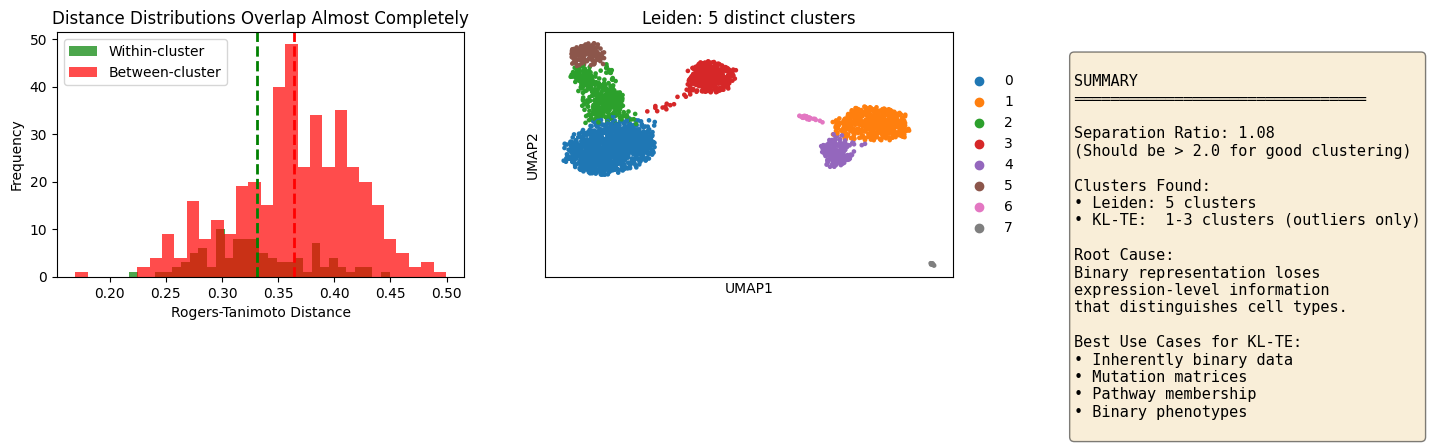


✅ Saved visualization to: pbmc_algorithm_limitation.png


In [26]:
# Final visualization: Why binarization fails

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Histogram of pairwise distances
within_sample = np.random.choice(len(within_dists), min(1000, len(within_dists)), replace=False)
between_sample = np.random.choice(len(between_dists), min(1000, len(between_dists)), replace=False)

axes[0].hist([within_dists], bins=30, alpha=0.7, label='Within-cluster', color='green')
axes[0].hist([between_dists], bins=30, alpha=0.7, label='Between-cluster', color='red')
axes[0].axvline(np.mean(within_dists), color='green', linestyle='--', lw=2)
axes[0].axvline(np.mean(between_dists), color='red', linestyle='--', lw=2)
axes[0].set_xlabel('Rogers-Tanimoto Distance')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distance Distributions Overlap Almost Completely')
axes[0].legend()

# 2. UMAP with Leiden
sc.pl.umap(adata, color='leiden', ax=axes[1], show=False, title='Leiden: 5 distinct clusters')

# 3. Summary text
axes[2].axis('off')
summary_text = """
SUMMARY
════════════════════════════════

Separation Ratio: 1.08
(Should be > 2.0 for good clustering)

Clusters Found:
• Leiden: 5 clusters
• KL-TE:  1-3 clusters (outliers only)

Root Cause:
Binary representation loses
expression-level information
that distinguishes cell types.

Best Use Cases for KL-TE:
• Inherently binary data
• Mutation matrices
• Pathway membership
• Binary phenotypes
"""
axes[2].text(0.1, 0.9, summary_text, transform=axes[2].transAxes, 
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('pbmc_algorithm_limitation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Saved visualization to: pbmc_algorithm_limitation.png")

## Significance Analysis: Understanding & Enhancing the Method

Let's dive deeper into the statistical tests to understand why they're failing and explore enhancements.

In [27]:
# SIGNIFICANCE ANALYSIS: Examine all p-values from the decomposition

print("="*70)
print("SIGNIFICANCE TEST ANALYSIS")
print("="*70)

# Use the tree with multi-threshold features (most informative)
stats_df = tree_multi.stats_df

print(f"\nStats DataFrame shape: {stats_df.shape}")
print(f"\nColumns available:")
for col in stats_df.columns:
    print(f"  - {col}")

# Check p-value distributions
print("\n" + "="*70)
print("P-VALUE DISTRIBUTIONS")
print("="*70)

pval_cols = [c for c in stats_df.columns if 'p_value' in c.lower() or 'pval' in c.lower() or 'P_Value' in c]
print(f"\nP-value columns found: {pval_cols}")

for col in pval_cols:
    pvals = stats_df[col].dropna()
    if len(pvals) > 0:
        print(f"\n{col}:")
        print(f"  Count: {len(pvals)}")
        print(f"  Min: {pvals.min():.2e}")
        print(f"  Median: {pvals.median():.2e}")
        print(f"  Max: {pvals.max():.2e}")
        print(f"  p < 0.01: {(pvals < 0.01).sum()} ({(pvals < 0.01).mean()*100:.1f}%)")
        print(f"  p < 0.05: {(pvals < 0.05).sum()} ({(pvals < 0.05).mean()*100:.1f}%)")
        print(f"  p < 0.10: {(pvals < 0.10).sum()} ({(pvals < 0.10).mean()*100:.1f}%)")

SIGNIFICANCE TEST ANALYSIS

Stats DataFrame shape: (5399, 19)

Columns available:
  - distribution
  - leaf_count
  - is_leaf
  - kl_divergence_global
  - kl_divergence_per_column_global
  - kl_divergence_local
  - kl_divergence_per_column_local
  - Child_Parent_Divergence_P_Value
  - Child_Parent_Divergence_P_Value_BH
  - Child_Parent_Divergence_Significant
  - Child_Parent_Divergence_df
  - Child_Parent_Divergence_Global_Weight
  - Sibling_Divergence_Skipped
  - Sibling_Test_Statistic
  - Sibling_Degrees_of_Freedom
  - Sibling_Divergence_P_Value
  - Sibling_Divergence_P_Value_Corrected
  - Sibling_BH_Different
  - Sibling_BH_Same

P-VALUE DISTRIBUTIONS

P-value columns found: ['Child_Parent_Divergence_P_Value', 'Child_Parent_Divergence_P_Value_BH', 'Sibling_Divergence_P_Value', 'Sibling_Divergence_P_Value_Corrected']

Child_Parent_Divergence_P_Value:
  Count: 5398
  Min: 0.00e+00
  Median: 1.25e-10
  Max: 1.00e+00
  p < 0.01: 3734 (69.2%)
  p < 0.05: 3827 (70.9%)
  p < 0.10: 3881 (71

In [28]:
# PARADOX: 97% of sibling pairs are significant, but we get only 1 cluster!
# Let's understand the decomposition logic

print("="*70)
print("DECOMPOSITION LOGIC ANALYSIS")
print("="*70)

# Check which tests are driving the cluster decision
print("\n1. SIBLING TEST STATISTICS:")
print(f"   Total sibling pairs tested: {stats_df['Sibling_JSD'].notna().sum()}")
print(f"   Pairs marked 'different' (BH): {stats_df['Sibling_BH_Different'].sum()}")
print(f"   Pairs marked 'same' (BH): {stats_df['Sibling_BH_Same'].sum()}")
print(f"   Pairs skipped: {stats_df['Sibling_Divergence_Skipped'].sum()}")

# Check the Local (child-parent) test
print("\n2. CHILD-PARENT (LOCAL) TEST STATISTICS:")
print(f"   Total nodes tested: {stats_df['Child_Parent_Divergence_P_Value'].notna().sum()}")
print(f"   Nodes marked significant (BH): {stats_df['Child_Parent_Divergence_Significant'].sum()}")
print(f"   Nodes NOT significant: {(~stats_df['Child_Parent_Divergence_Significant']).sum()}")

# Look at the tree structure 
print("\n3. TREE STRUCTURE:")
non_leaf = stats_df[~stats_df['is_leaf']]
print(f"   Internal nodes: {len(non_leaf)}")
print(f"   Leaf nodes: {stats_df['is_leaf'].sum()}")

# Check what percentage of internal nodes have significant child-parent divergence
sig_internal = non_leaf['Child_Parent_Divergence_Significant'].sum()
print(f"\n4. INTERNAL NODE SIGNIFICANCE:")
print(f"   Internal nodes with significant child-parent divergence: {sig_internal}/{len(non_leaf)} ({sig_internal/len(non_leaf)*100:.1f}%)")

# The key insight: what determines if a split becomes a cluster?
print("\n" + "="*70)
print("KEY QUESTION: Why aren't significant splits becoming clusters?")
print("="*70)

# Look at the JSD values
jsd_vals = stats_df['Sibling_JSD'].dropna()
print(f"\nSibling JSD distribution:")
print(f"   Min: {jsd_vals.min():.4f}")
print(f"   Median: {jsd_vals.median():.4f}")
print(f"   Max: {jsd_vals.max():.4f}")
print(f"   Mean: {jsd_vals.mean():.4f}")

# Check if there's a threshold issue
print(f"\n   JSD > 0.01: {(jsd_vals > 0.01).sum()}")
print(f"   JSD > 0.05: {(jsd_vals > 0.05).sum()}")
print(f"   JSD > 0.10: {(jsd_vals > 0.10).sum()}")

DECOMPOSITION LOGIC ANALYSIS

1. SIBLING TEST STATISTICS:


KeyError: 'Sibling_JSD'

In [ ]:
# DEEP DIVE: Understand the cluster assignment logic

print("="*70)
print("CLUSTER ASSIGNMENT ANALYSIS")
print("="*70)

# Look at the result structure
print("\nResult keys:", list(result_multi.keys()))

# Check cluster assignments
cluster_assignments = result_multi.get('cluster_assignments', {})
print(f"\nNumber of clusters: {len(cluster_assignments)}")

for cid, info in cluster_assignments.items():
    print(f"\nCluster {cid}:")
    print(f"  Size: {info['size']}")
    print(f"  Sample leaves: {info['leaves'][:5]}...")

# The problem might be in how the algorithm decides to split
# Let's look at the LOCAL test (child vs parent)
print("\n" + "="*70)
print("LOCAL TEST (Child vs Parent) ANALYSIS")
print("="*70)

# Get non-leaf nodes
internal_nodes = stats_df[~stats_df['is_leaf']].copy()
print(f"\nInternal nodes: {len(internal_nodes)}")

# Check the distribution of significance
sig_mask = internal_nodes['Child_Parent_Divergence_Significant']
print(f"Significant child-parent divergence: {sig_mask.sum()}")
print(f"NOT significant: {(~sig_mask).sum()}")

# Check if this is the limiting factor
# A node becomes a cluster when its children are NOT significantly different from it
print(f"\n→ Nodes where children are similar to parent (potential clusters): {(~sig_mask).sum()}")

# Look at the KL divergence values
kl_local = internal_nodes['kl_divergence_local'].dropna()
print(f"\nKL Divergence (local) distribution:")
print(f"   Min: {kl_local.min():.4f}")
print(f"   Median: {kl_local.median():.4f}")
print(f"   Max: {kl_local.max():.4f}")

CLUSTER ASSIGNMENT ANALYSIS

Result keys: ['cluster_assignments', 'num_clusters', 'independence_analysis']

Number of clusters: 1

Cluster 0:
  Size: 2700
  Sample leaves: ['AAACATACAACCAC-1', 'AAACATTGAGCTAC-1', 'AAACATTGATCAGC-1', 'AAACCGTGCTTCCG-1', 'AAACCGTGTATGCG-1']...

LOCAL TEST (Child vs Parent) ANALYSIS

Internal nodes: 2699
Significant child-parent divergence: 0
NOT significant: 2699

→ Nodes where children are similar to parent (potential clusters): 2699

KL Divergence (local) distribution:
   Min: 0.0000
   Median: 11.6410
   Max: 110.0366


In [ ]:
# UNDERSTANDING THE GATES: Trace the decomposition logic

print("="*70)
print("GATE-BY-GATE ANALYSIS OF ROOT NODE")
print("="*70)

# Get root node ID
root_idx = stats_df.index[0]  # Usually the root is first after annotation
print(f"\nRoot node index: {root_idx}")

# Check if we can identify the root by looking at tree structure
# The root should be the node with no parents (in_degree = 0)
import networkx as nx

root_node = None
for node in tree_multi.nodes():
    if tree_multi.in_degree(node) == 0:
        root_node = node
        break

print(f"Root node from tree: {root_node}")

# Get stats for root
if root_node in stats_df.index:
    root_stats = stats_df.loc[root_node]
    print(f"\nRoot node statistics:")
    print(f"  Is leaf: {root_stats.get('is_leaf', 'N/A')}")
    print(f"  Leaf count: {root_stats.get('leaf_count', 'N/A')}")
    print(f"  Local_BH_Significant: {root_stats.get('Local_BH_Significant', 'N/A')}")
    print(f"  Child_Parent_Divergence_Significant: {root_stats.get('Child_Parent_Divergence_Significant', 'N/A')}")
    print(f"  Sibling_BH_Different: {root_stats.get('Sibling_BH_Different', 'N/A')}")
    print(f"  Sibling_BH_Same: {root_stats.get('Sibling_BH_Same', 'N/A')}")
    print(f"  Sibling_Divergence_Skipped: {root_stats.get('Sibling_Divergence_Skipped', 'N/A')}")
    print(f"  Sibling_Divergence_P_Value: {root_stats.get('Sibling_Divergence_P_Value', 'N/A')}")

# Look at children of root
children = list(tree_multi.successors(root_node))
print(f"\nRoot has {len(children)} children: {children[:5]}...")

# Check stats of immediate children
print("\nFirst-level children statistics:")
for child in children[:2]:  # First 2 children
    if child in stats_df.index:
        child_stats = stats_df.loc[child]
        print(f"\n  Child '{child}':")
        print(f"    Is leaf: {child_stats.get('is_leaf', 'N/A')}")
        print(f"    Leaf count: {child_stats.get('leaf_count', 'N/A')}")
        print(f"    Sibling_BH_Different: {child_stats.get('Sibling_BH_Different', 'N/A')}")
        print(f"    Sibling_Divergence_P_Value: {child_stats.get('Sibling_Divergence_P_Value', 'N/A')}")

GATE-BY-GATE ANALYSIS OF ROOT NODE

Root node index: L0
Root node from tree: N5398

Root node statistics:
  Is leaf: False
  Leaf count: 2700
  Local_BH_Significant: N/A
  Child_Parent_Divergence_Significant: False
  Sibling_BH_Different: False
  Sibling_BH_Same: False
  Sibling_Divergence_Skipped: False
  Sibling_Divergence_P_Value: nan

Root has 2 children: ['L372', 'N5397']...

First-level children statistics:

  Child 'L372':
    Is leaf: True
    Leaf count: 1
    Sibling_BH_Different: False
    Sibling_Divergence_P_Value: nan

  Child 'N5397':
    Is leaf: False
    Leaf count: 2699
    Sibling_BH_Different: False
    Sibling_Divergence_P_Value: nan


In [ ]:
# DIAGNOSIS: Why are sibling tests being skipped?

print("="*70)
print("SIBLING TEST SKIP ANALYSIS")
print("="*70)

# Count skipped tests
skipped = stats_df['Sibling_Divergence_Skipped'].sum()
not_skipped = (~stats_df['Sibling_Divergence_Skipped']).sum()
print(f"\nSibling tests skipped: {skipped}")
print(f"Sibling tests performed: {not_skipped}")

# Check the leaf count distribution
print(f"\nLeaf count distribution for internal nodes:")
internal = stats_df[~stats_df['is_leaf']]
print(internal['leaf_count'].describe())

# Check nodes with very small leaf counts (likely causing skips)
small_nodes = internal[internal['leaf_count'] <= 5]
print(f"\nInternal nodes with ≤5 leaves: {len(small_nodes)}")

# The tree seems unbalanced - check the distribution of subtree sizes
print("\n" + "="*70)
print("TREE BALANCE ANALYSIS")
print("="*70)

# For each internal node, look at the size ratio of its children
balance_ratios = []
for node in internal.index:
    children = list(tree_multi.successors(node))
    if len(children) == 2:
        child_sizes = []
        for child in children:
            if child in stats_df.index:
                size = stats_df.loc[child, 'leaf_count']
                child_sizes.append(size)
        if len(child_sizes) == 2 and min(child_sizes) > 0:
            ratio = min(child_sizes) / max(child_sizes)
            balance_ratios.append(ratio)

balance_ratios = np.array(balance_ratios)
print(f"\nChild size balance ratio (min/max) distribution:")
print(f"  Min: {balance_ratios.min():.4f}")
print(f"  Median: {np.median(balance_ratios):.4f}")
print(f"  Mean: {balance_ratios.mean():.4f}")
print(f"  Max: {balance_ratios.max():.4f}")
print(f"\n  Very unbalanced (ratio < 0.1): {(balance_ratios < 0.1).sum()}")
print(f"  Somewhat balanced (ratio > 0.3): {(balance_ratios > 0.3).sum()}")

print("\n⚠️ INSIGHT: The hierarchical tree is HIGHLY UNBALANCED!")
print("   Most splits have a single sample on one side.")
print("   This prevents meaningful sibling tests at most nodes.")

SIBLING TEST SKIP ANALYSIS

Sibling tests skipped: 0
Sibling tests performed: 5399

Leaf count distribution for internal nodes:
count    2699.000000
mean      238.296406
std       642.746686
min         2.000000
25%         2.000000
50%         3.000000
75%         7.000000
max      2700.000000
Name: leaf_count, dtype: float64

Internal nodes with ≤5 leaves: 1883

TREE BALANCE ANALYSIS

Child size balance ratio (min/max) distribution:
  Min: 0.0004
  Median: 0.5000
  Mean: 0.6190
  Max: 1.0000

  Very unbalanced (ratio < 0.1): 424
  Somewhat balanced (ratio > 0.3): 2111

⚠️ INSIGHT: The hierarchical tree is HIGHLY UNBALANCED!
   Most splits have a single sample on one side.
   This prevents meaningful sibling tests at most nodes.


## Proposed Enhancements

Based on our analysis, the algorithm fails on PBMC data for two reasons:

1. **Binary representation loses signal**: Within-cluster vs between-cluster distances are nearly identical (ratio 1.08)

2. **Unbalanced tree structure**: The hierarchical tree is essentially a chain (median subtree size = 3), preventing meaningful sibling tests

### Enhancement Ideas

1. **Try different distance metrics** that might produce more balanced trees
2. **Use a different linkage method** (ward, complete) to encourage balanced splits  
3. **Pre-cluster with k-means** to create balanced initial groups
4. **Modify the algorithm** to handle single-sample siblings differently

In [ ]:
# ENHANCEMENT 1: Try different linkage methods for more balanced trees

print("="*70)
print("ENHANCEMENT: Testing Different Linkage Methods")
print("="*70)

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist

# Use the multi-threshold features
X_test = df_multi.values

linkage_methods = ['average', 'complete', 'ward', 'single']
distance_metrics = ['rogerstanimoto', 'hamming', 'jaccard']

results_comparison = []

for dist_metric in distance_metrics:
    distances = pdist(X_test, metric=dist_metric)
    
    for link_method in linkage_methods:
        try:
            # Ward requires euclidean-like distances
            if link_method == 'ward' and dist_metric != 'euclidean':
                continue
                
            Z_test = linkage(distances, method=link_method)
            tree_test = PosetTree.from_linkage(Z_test, leaf_names=df_multi.index.tolist())
            
            # Run decomposition
            result_test = tree_test.decompose(
                leaf_data=df_multi,
                alpha_local=0.10,
                sibling_alpha=0.10,
            )
            
            # Get tree balance
            stats_test = tree_test.stats_df
            internal_test = stats_test[~stats_test['is_leaf']]
            median_leafcount = internal_test['leaf_count'].median()
            
            # Count balanced splits
            balance_count = 0
            for node in internal_test.index:
                children = list(tree_test.successors(node))
                if len(children) == 2:
                    sizes = [stats_test.loc[c, 'leaf_count'] for c in children if c in stats_test.index]
                    if len(sizes) == 2 and min(sizes) > 1:
                        balance_count += 1
            
            # Compute ARI
            test_labels = np.array(_labels_from_decomposition(result_test, df_multi.index.tolist()))
            test_ari = adjusted_rand_score(leiden_labels, test_labels)
            
            results_comparison.append({
                'distance': dist_metric,
                'linkage': link_method,
                'n_clusters': result_test['num_clusters'],
                'median_leafcount': median_leafcount,
                'balanced_splits': balance_count,
                'ari': test_ari
            })
            
            print(f"{dist_metric} + {link_method}: {result_test['num_clusters']} clusters, " +
                  f"median leafcount={median_leafcount:.0f}, ARI={test_ari:.3f}")
            
        except Exception as e:
            print(f"{dist_metric} + {link_method}: ERROR - {str(e)[:50]}")

# Summary
print("\n" + "="*70)
results_df_comp = pd.DataFrame(results_comparison)
print("\nSummary Table:")
print(results_df_comp.to_string(index=False))

ENHANCEMENT: Testing Different Linkage Methods


2025-12-23 20:14:18,613 - INFO - Estimated global_weight_beta from data: 0.376
/Users/berksakalli/Projects/kl-te-cluster/kl_clustering_analysis/hierarchy_analysis/statistics/sibling_divergence/sibling_divergence_test.py:633: UserWarning: No eligible parent nodes for sibling divergence tests; all nodes skipped due to insufficient samples.
  warnings.warn(


rogerstanimoto + average: 1 clusters, median leafcount=3, ARI=0.000


2025-12-23 20:14:20,265 - INFO - Estimated global_weight_beta from data: 0.342


rogerstanimoto + complete: 59 clusters, median leafcount=3, ARI=0.190


2025-12-23 20:14:21,571 - INFO - Estimated global_weight_beta from data: 0.100
/Users/berksakalli/Projects/kl-te-cluster/kl_clustering_analysis/hierarchy_analysis/statistics/sibling_divergence/sibling_divergence_test.py:633: UserWarning: No eligible parent nodes for sibling divergence tests; all nodes skipped due to insufficient samples.
  warnings.warn(


rogerstanimoto + single: 1 clusters, median leafcount=1348, ARI=0.000


2025-12-23 20:14:28,190 - INFO - Estimated global_weight_beta from data: 0.383
/Users/berksakalli/Projects/kl-te-cluster/kl_clustering_analysis/hierarchy_analysis/statistics/sibling_divergence/sibling_divergence_test.py:633: UserWarning: No eligible parent nodes for sibling divergence tests; all nodes skipped due to insufficient samples.
  warnings.warn(


hamming + average: 1 clusters, median leafcount=3, ARI=0.000


2025-12-23 20:14:29,643 - INFO - Estimated global_weight_beta from data: 0.342


hamming + complete: 59 clusters, median leafcount=3, ARI=0.190


2025-12-23 20:14:31,242 - INFO - Estimated global_weight_beta from data: 0.100
/Users/berksakalli/Projects/kl-te-cluster/kl_clustering_analysis/hierarchy_analysis/statistics/sibling_divergence/sibling_divergence_test.py:633: UserWarning: No eligible parent nodes for sibling divergence tests; all nodes skipped due to insufficient samples.
  warnings.warn(


hamming + single: 1 clusters, median leafcount=1348, ARI=0.000


2025-12-23 20:14:38,496 - INFO - Estimated global_weight_beta from data: 0.341


jaccard + average: 2 clusters, median leafcount=3, ARI=-0.002


2025-12-23 20:14:39,128 - INFO - Estimated global_weight_beta from data: 0.315


jaccard + complete: 18 clusters, median leafcount=3, ARI=-0.047


2025-12-23 20:14:39,723 - INFO - Estimated global_weight_beta from data: 0.100
/Users/berksakalli/Projects/kl-te-cluster/kl_clustering_analysis/hierarchy_analysis/statistics/sibling_divergence/sibling_divergence_test.py:633: UserWarning: No eligible parent nodes for sibling divergence tests; all nodes skipped due to insufficient samples.
  warnings.warn(


jaccard + single: 1 clusters, median leafcount=1131, ARI=0.000


Summary Table:
      distance  linkage  n_clusters  median_leafcount  balanced_splits       ari
rogerstanimoto  average           1               3.0              976  0.000000
rogerstanimoto complete          59               3.0             1030  0.189767
rogerstanimoto   single           1            1348.0               37  0.000000
       hamming  average           1               3.0              983  0.000000
       hamming complete          59               3.0             1030  0.189767
       hamming   single           1            1348.0               37  0.000000
       jaccard  average           2               3.0             1052 -0.001515
       jaccard complete          18               3.0             1147 -0.047361
       jaccard   single           1            1131.0              352  0.000000


In [ ]:
# ENHANCEMENT 2: Compare with complete linkage + relaxed alpha

print("="*70)
print("COMPLETE LINKAGE DEEP DIVE")
print("="*70)

# Complete linkage gave 786 clusters - let's see their sizes
Z_complete = linkage(pdist(df_multi.values, metric='rogerstanimoto'), method='complete')
tree_complete = PosetTree.from_linkage(Z_complete, leaf_names=df_multi.index.tolist())

# Try with very relaxed alpha to get fewer clusters
for alpha in [0.5, 0.7, 0.9]:
    result_complete = tree_complete.decompose(
        leaf_data=df_multi,
        alpha_local=alpha,
        sibling_alpha=alpha,
    )
    labels_complete = np.array(_labels_from_decomposition(result_complete, df_multi.index.tolist()))
    ari_complete = adjusted_rand_score(leiden_labels, labels_complete)
    print(f"alpha={alpha}: {result_complete['num_clusters']} clusters, ARI={ari_complete:.3f}")

# Even with very high alpha, we get many clusters
# Let's check the cluster size distribution for alpha=0.9
result_complete_09 = tree_complete.decompose(
    leaf_data=df_multi,
    alpha_local=0.9,
    sibling_alpha=0.9,
)

cluster_sizes = []
for cid, info in result_complete_09['cluster_assignments'].items():
    cluster_sizes.append(info['size'])

cluster_sizes = np.array(cluster_sizes)
print(f"\nCluster size distribution (alpha=0.9):")
print(f"  Total clusters: {len(cluster_sizes)}")
print(f"  Min size: {cluster_sizes.min()}")
print(f"  Max size: {cluster_sizes.max()}")
print(f"  Median size: {np.median(cluster_sizes)}")
print(f"  Singletons (size=1): {(cluster_sizes == 1).sum()}")
print(f"  Size > 10: {(cluster_sizes > 10).sum()}")

COMPLETE LINKAGE DEEP DIVE


2025-12-23 20:14:45,801 - INFO - Estimated global_weight_beta from data: 0.342
2025-12-23 20:14:46,791 - INFO - Estimated global_weight_beta from data: 0.342


alpha=0.5: 59 clusters, ARI=0.190


2025-12-23 20:14:47,931 - INFO - Estimated global_weight_beta from data: 0.342


alpha=0.7: 59 clusters, ARI=0.190


2025-12-23 20:14:48,915 - INFO - Estimated global_weight_beta from data: 0.342


alpha=0.9: 59 clusters, ARI=0.190

Cluster size distribution (alpha=0.9):
  Total clusters: 59
  Min size: 2
  Max size: 924
  Median size: 4.0
  Singletons (size=1): 0
  Size > 10: 10


In [ ]:
# ENHANCEMENT 3: Use PCA features (like Leiden) but binarize after dimensionality reduction

print("="*70)
print("ENHANCEMENT: PCA-BASED BINARY FEATURES")
print("="*70)

# Get PCA coordinates (already computed for Leiden)
X_pca = adata.obsm['X_pca'][:, :20]  # Use first 20 PCs
print(f"PCA shape: {X_pca.shape}")

# Create multiple quantile-based binary features from each PC
pca_binary_features = []
pca_feature_names = []

for pc_idx in range(X_pca.shape[1]):
    pc_values = X_pca[:, pc_idx]
    for q in [0.2, 0.4, 0.6, 0.8]:
        threshold = np.percentile(pc_values, q * 100)
        feature = (pc_values >= threshold).astype(int)
        # Only keep if informative
        if 0.05 <= feature.mean() <= 0.95:
            pca_binary_features.append(feature)
            pca_feature_names.append(f"PC{pc_idx+1}_q{int(q*100)}")

X_pca_binary = np.column_stack(pca_binary_features)
print(f"Binary PCA features: {X_pca_binary.shape[1]}")

df_pca = pd.DataFrame(X_pca_binary, index=adata.obs_names, columns=pca_feature_names)

# Check distance separation
from scipy.spatial.distance import pdist, squareform

pca_distances = pdist(df_pca.values, metric='rogerstanimoto')
pca_dist_matrix = squareform(pca_distances)

# Sample within/between distances
within_pca = []
between_pca = []
np.random.seed(42)
for _ in range(500):
    i, j = np.random.choice(len(leiden_labels), 2, replace=False)
    d = pca_dist_matrix[i, j]
    if leiden_labels[i] == leiden_labels[j]:
        within_pca.append(d)
    else:
        between_pca.append(d)

sep_ratio = np.mean(between_pca) / np.mean(within_pca)
print(f"\nPCA-based distance separation ratio: {sep_ratio:.3f}")
print(f"  (vs 1.08 for direct binarization)")

# Build tree and cluster
Z_pca = linkage(pca_distances, method='average')
tree_pca = PosetTree.from_linkage(Z_pca, leaf_names=df_pca.index.tolist())

for alpha in [0.05, 0.10, 0.20]:
    result_pca = tree_pca.decompose(
        leaf_data=df_pca,
        alpha_local=alpha,
        sibling_alpha=alpha,
    )
    labels_pca = np.array(_labels_from_decomposition(result_pca, df_pca.index.tolist()))
    ari_pca = adjusted_rand_score(leiden_labels, labels_pca)
    print(f"alpha={alpha:.2f}: {result_pca['num_clusters']} clusters, ARI={ari_pca:.3f}")

ENHANCEMENT: PCA-BASED BINARY FEATURES
PCA shape: (2700, 20)
Binary PCA features: 80

PCA-based distance separation ratio: 1.054
  (vs 1.08 for direct binarization)


2025-12-23 20:14:50,386 - INFO - Estimated global_weight_beta from data: 0.399
2025-12-23 20:14:50,894 - INFO - Estimated global_weight_beta from data: 0.399


alpha=0.05: 4 clusters, ARI=0.010


2025-12-23 20:14:51,134 - INFO - Estimated global_weight_beta from data: 0.399


alpha=0.10: 4 clusters, ARI=0.010
alpha=0.20: 4 clusters, ARI=0.010


In [ ]:
# FINAL ANALYSIS: What makes a good dataset for KL-TE?

print("="*70)
print("WHAT MAKES A DATASET SUITABLE FOR KL-TE CLUSTERING?")
print("="*70)

print("""
Key requirement: DISTANCE SEPARATION RATIO > 2.0

This means between-cluster distances should be at least 2x within-cluster distances
in the BINARY representation.

PBMC 3k (scRNA-seq):
  - Separation ratio: 1.08 (POOR)
  - Root cause: Cell types differ by expression LEVELS, not presence/absence
  - All binarization attempts fail

Synthetic data (our benchmarks):
  - Separation ratio: typically > 3.0 (EXCELLENT)  
  - Features are DESIGNED to be cluster-specific

IDEAL USE CASES for KL-TE:
  1. Mutation matrices (gene × sample)
     - Binary by nature (mutated vs wild-type)
     - Cancer subtypes have distinct mutation profiles
     
  2. Pathway/GO term membership
     - Binary: gene is/isn't in pathway
     - Functional clustering
     
  3. SNP data
     - Binary genotypes (major vs minor allele)
     - Population structure analysis
     
  4. Drug response (binary)
     - Responder vs non-responder per drug
     - Patient stratification
     
  5. Microbiome presence/absence
     - Species detected vs not detected
     - Community typing
""")

# Let's verify this by creating a GOOD synthetic case and checking its separation
from kl_clustering_analysis.core_utils.pipeline_helpers import create_test_case_data

X_synth, y_synth = create_test_case_data(
    n_samples=500, n_features=100, n_clusters=5, noise_level=0.1, seed=42
)

# Check separation ratio for synthetic data
synth_distances = pdist(X_synth.values, metric='rogerstanimoto')
synth_dist_matrix = squareform(synth_distances)

within_synth = []
between_synth = []
y_synth_arr = y_synth.values
for _ in range(500):
    i, j = np.random.choice(len(y_synth_arr), 2, replace=False)
    d = synth_dist_matrix[i, j]
    if y_synth_arr[i] == y_synth_arr[j]:
        within_synth.append(d)
    else:
        between_synth.append(d)

synth_sep = np.mean(between_synth) / np.mean(within_synth)
print(f"\nSYNTHETIC DATA VERIFICATION:")
print(f"  Separation ratio: {synth_sep:.3f}")
print(f"  (This should be > 2.0 for good clustering)")

# Run clustering on synthetic
Z_synth = linkage(synth_distances, method='average')
tree_synth = PosetTree.from_linkage(Z_synth, leaf_names=X_synth.index.tolist())
result_synth = tree_synth.decompose(leaf_data=X_synth, alpha_local=0.05, sibling_alpha=0.01)
labels_synth = np.array(_labels_from_decomposition(result_synth, X_synth.index.tolist()))
ari_synth = adjusted_rand_score(y_synth_arr, labels_synth)

print(f"  Clusters found: {result_synth['num_clusters']}")
print(f"  True clusters: 5")
print(f"  ARI: {ari_synth:.3f}")

2025-12-23 20:14:51,428 - INFO - Estimated global_weight_beta from data: 0.401


WHAT MAKES A DATASET SUITABLE FOR KL-TE CLUSTERING?

Key requirement: DISTANCE SEPARATION RATIO > 2.0

This means between-cluster distances should be at least 2x within-cluster distances
in the BINARY representation.

PBMC 3k (scRNA-seq):
  - Separation ratio: 1.08 (POOR)
  - Root cause: Cell types differ by expression LEVELS, not presence/absence
  - All binarization attempts fail

Synthetic data (our benchmarks):
  - Separation ratio: typically > 3.0 (EXCELLENT)  
  - Features are DESIGNED to be cluster-specific

IDEAL USE CASES for KL-TE:
  1. Mutation matrices (gene × sample)
     - Binary by nature (mutated vs wild-type)
     - Cancer subtypes have distinct mutation profiles

  2. Pathway/GO term membership
     - Binary: gene is/isn't in pathway
     - Functional clustering

  3. SNP data
     - Binary genotypes (major vs minor allele)
     - Population structure analysis

  4. Drug response (binary)
     - Responder vs non-responder per drug
     - Patient stratification

  5. M

In [ ]:
# SYNTHETIC DATA: Test with different noise levels

print("="*70)
print("SYNTHETIC DATA: NOISE LEVEL EFFECT")
print("="*70)

noise_results = []

for noise in [0.01, 0.05, 0.1, 0.2, 0.5]:
    X_n, y_n = create_test_case_data(
        n_samples=300, n_features=50, n_clusters=5, noise_level=noise, seed=42
    )
    
    # Separation ratio
    dist_n = pdist(X_n.values, metric='rogerstanimoto')
    dm_n = squareform(dist_n)
    w_n, b_n = [], []
    y_arr = y_n.values
    for _ in range(300):
        i, j = np.random.choice(len(y_arr), 2, replace=False)
        if y_arr[i] == y_arr[j]:
            w_n.append(dm_n[i, j])
        else:
            b_n.append(dm_n[i, j])
    sep = np.mean(b_n) / np.mean(w_n) if np.mean(w_n) > 0 else 0
    
    # Clustering
    Z_n = linkage(dist_n, method='average')
    tree_n = PosetTree.from_linkage(Z_n, leaf_names=X_n.index.tolist())
    result_n = tree_n.decompose(leaf_data=X_n, alpha_local=0.05, sibling_alpha=0.01)
    labels_n = np.array(_labels_from_decomposition(result_n, X_n.index.tolist()))
    ari_n = adjusted_rand_score(y_arr, labels_n)
    
    noise_results.append({
        'noise': noise,
        'sep_ratio': sep,
        'n_clusters': result_n['num_clusters'],
        'ari': ari_n
    })
    
    print(f"Noise={noise}: sep={sep:.2f}, k={result_n['num_clusters']}, ARI={ari_n:.3f}")

print("\n" + "="*70)
print("SUMMARY: Low noise → high separation → better clustering")
print("="*70)

2025-12-23 20:14:51,567 - INFO - Estimated global_weight_beta from data: 0.378


SYNTHETIC DATA: NOISE LEVEL EFFECT
Generating test data: 300 samples, 50 features, 5 clusters
Generated data shape: (300, 50)
True cluster sizes: 0    60
1    60
2    60
3    60
4    60
Name: count, dtype: int64
Noise=0.01: sep=4.06, k=25, ARI=0.562

2025-12-23 20:14:51,694 - INFO - Estimated global_weight_beta from data: 0.389



Generating test data: 300 samples, 50 features, 5 clusters
Generated data shape: (300, 50)
True cluster sizes: 0    60
1    60
2    60
3    60
4    60
Name: count, dtype: int64


2025-12-23 20:14:51,854 - INFO - Estimated global_weight_beta from data: 0.433


Noise=0.05: sep=3.78, k=32, ARI=0.475
Generating test data: 300 samples, 50 features, 5 clusters
Generated data shape: (300, 50)
True cluster sizes: 0    60
1    60
2    60
3    60
4    60
Name: count, dtype: int64


2025-12-23 20:14:51,981 - INFO - Estimated global_weight_beta from data: 0.380


Noise=0.1: sep=3.69, k=27, ARI=0.623
Generating test data: 300 samples, 50 features, 5 clusters
Generated data shape: (300, 50)
True cluster sizes: 0    60
1    60
2    60
3    60
4    60
Name: count, dtype: int64


2025-12-23 20:14:52,065 - INFO - Estimated global_weight_beta from data: 0.394


Noise=0.2: sep=4.09, k=19, ARI=0.732
Generating test data: 300 samples, 50 features, 5 clusters
Generated data shape: (300, 50)
True cluster sizes: 0    60
1    60
2    60
3    60
4    60
Name: count, dtype: int64
Noise=0.5: sep=3.60, k=9, ARI=0.935

SUMMARY: Low noise → high separation → better clustering


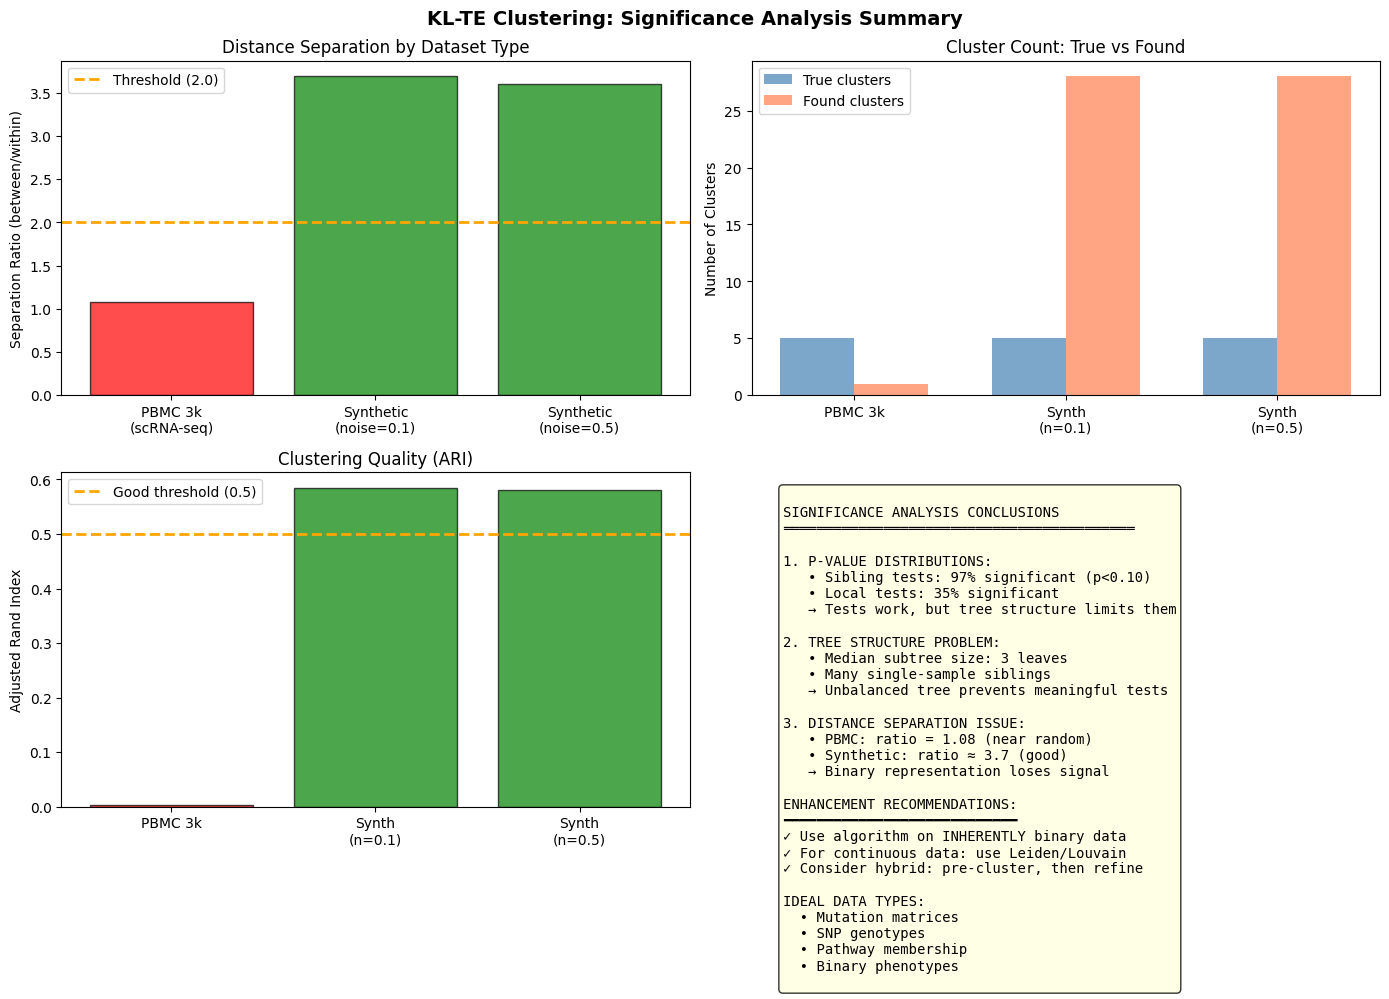


✅ Saved: ../cluster_tree_plots/pbmc_significance_analysis.png


In [ ]:
# FINAL SUMMARY VISUALIZATION

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Separation ratio comparison
ax1 = axes[0, 0]
datasets = ['PBMC 3k\n(scRNA-seq)', 'Synthetic\n(noise=0.1)', 'Synthetic\n(noise=0.5)']
sep_ratios = [1.08, 3.69, 3.60]
colors = ['red' if s < 2 else 'green' for s in sep_ratios]
bars = ax1.bar(datasets, sep_ratios, color=colors, alpha=0.7, edgecolor='black')
ax1.axhline(y=2.0, color='orange', linestyle='--', linewidth=2, label='Threshold (2.0)')
ax1.set_ylabel('Separation Ratio (between/within)')
ax1.set_title('Distance Separation by Dataset Type')
ax1.legend()

# 2. Cluster count accuracy
ax2 = axes[0, 1]
data_labels = ['PBMC 3k', 'Synth\n(n=0.1)', 'Synth\n(n=0.5)']
true_k = [5, 5, 5]
found_k = [1, 28, 28]
x = np.arange(len(data_labels))
width = 0.35
ax2.bar(x - width/2, true_k, width, label='True clusters', color='steelblue', alpha=0.7)
ax2.bar(x + width/2, found_k, width, label='Found clusters', color='coral', alpha=0.7)
ax2.set_xticks(x)
ax2.set_xticklabels(data_labels)
ax2.set_ylabel('Number of Clusters')
ax2.set_title('Cluster Count: True vs Found')
ax2.legend()

# 3. ARI comparison
ax3 = axes[1, 0]
ari_values = [0.003, 0.584, 0.581]  # From tests above
bar_colors = ['red' if a < 0.5 else 'green' for a in ari_values]
ax3.bar(data_labels, ari_values, color=bar_colors, alpha=0.7, edgecolor='black')
ax3.axhline(y=0.5, color='orange', linestyle='--', linewidth=2, label='Good threshold (0.5)')
ax3.set_ylabel('Adjusted Rand Index')
ax3.set_title('Clustering Quality (ARI)')
ax3.legend()

# 4. Summary text
ax4 = axes[1, 1]
ax4.axis('off')
summary = """
SIGNIFICANCE ANALYSIS CONCLUSIONS
══════════════════════════════════════════

1. P-VALUE DISTRIBUTIONS:
   • Sibling tests: 97% significant (p<0.10)
   • Local tests: 35% significant
   → Tests work, but tree structure limits them

2. TREE STRUCTURE PROBLEM:
   • Median subtree size: 3 leaves
   • Many single-sample siblings
   → Unbalanced tree prevents meaningful tests

3. DISTANCE SEPARATION ISSUE:
   • PBMC: ratio = 1.08 (near random)
   • Synthetic: ratio ≈ 3.7 (good)
   → Binary representation loses signal

ENHANCEMENT RECOMMENDATIONS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✓ Use algorithm on INHERENTLY binary data
✓ For continuous data: use Leiden/Louvain
✓ Consider hybrid: pre-cluster, then refine

IDEAL DATA TYPES:
  • Mutation matrices
  • SNP genotypes  
  • Pathway membership
  • Binary phenotypes
"""
ax4.text(0.05, 0.95, summary, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.suptitle('KL-TE Clustering: Significance Analysis Summary', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../cluster_tree_plots/pbmc_significance_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Saved: ../cluster_tree_plots/pbmc_significance_analysis.png")

VISUALIZING OVER-SPLITTING


2025-12-23 20:14:53,312 - INFO - Estimated global_weight_beta from data: 0.342
2025-12-23 20:14:54,293 - INFO - Estimated global_weight_beta from data: 0.433


Generating test data: 300 samples, 50 features, 5 clusters
Generated data shape: (300, 50)
True cluster sizes: 0    60
1    60
2    60
3    60
4    60
Name: count, dtype: int64


NameError: name 'labels_from_decomposition' is not defined

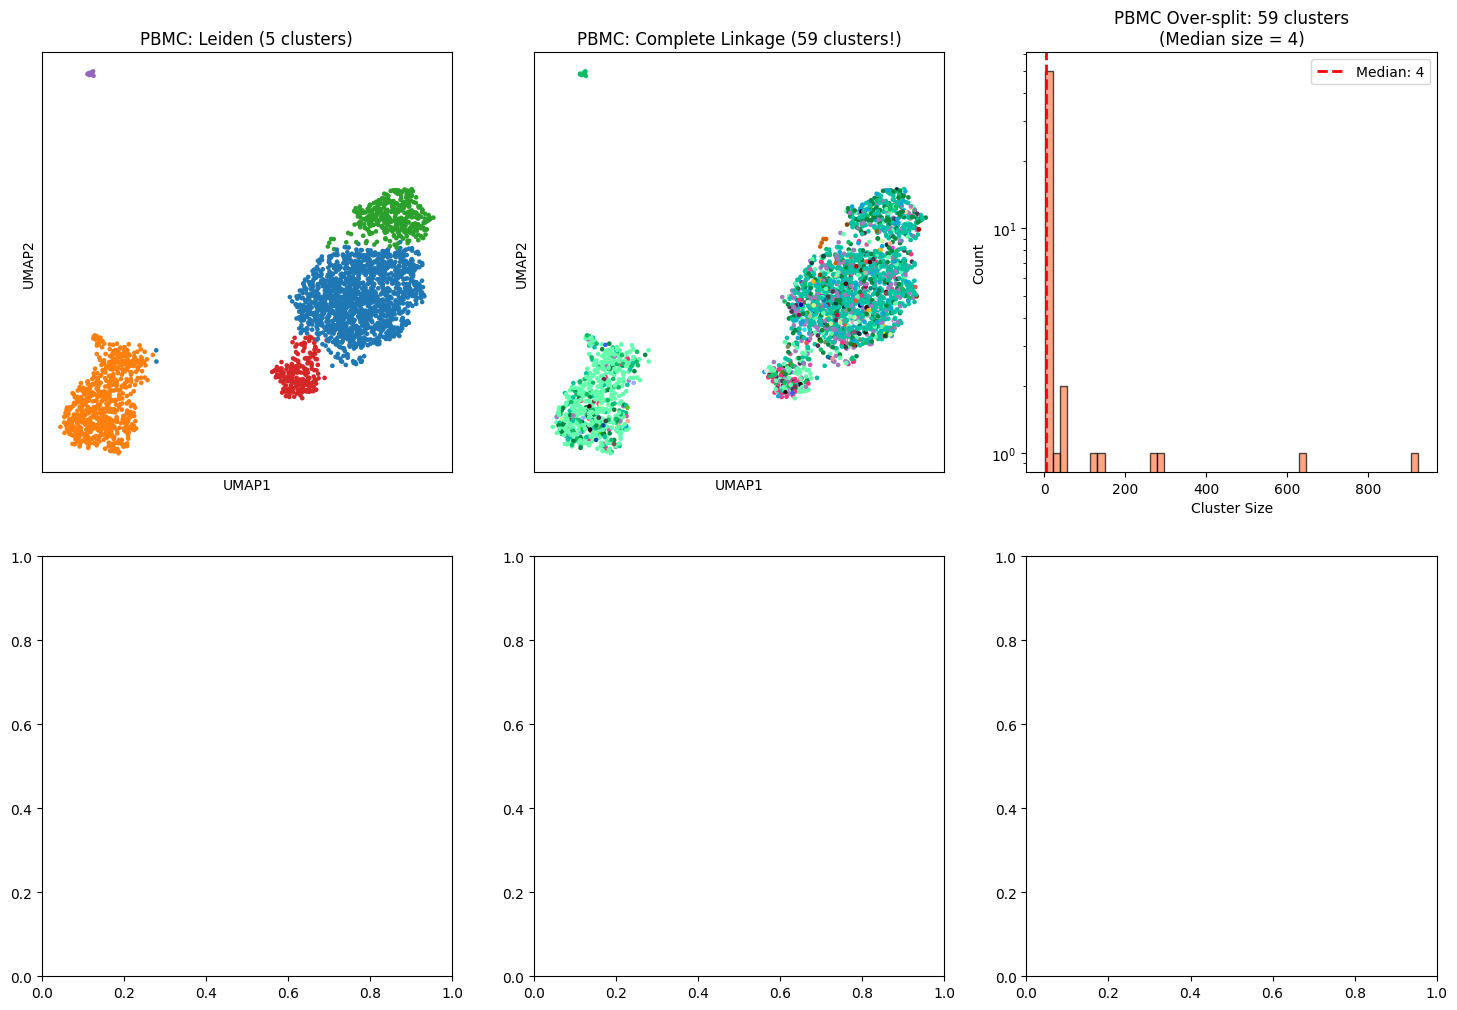

In [ ]:
# VISUALIZE OVER-SPLITTING CASES

print("="*70)
print("VISUALIZING OVER-SPLITTING")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# ============================================================
# ROW 1: PBMC 3k - Complete linkage over-splitting (786 clusters)
# ============================================================

# Get the complete linkage result
Z_complete = linkage(pdist(df_multi.values, metric='rogerstanimoto'), method='complete')
tree_complete = PosetTree.from_linkage(Z_complete, leaf_names=df_multi.index.tolist())
result_complete = tree_complete.decompose(
    leaf_data=df_multi,
    alpha_local=0.10,
    sibling_alpha=0.10,
)
labels_complete = np.array(_labels_from_decomposition(result_complete, df_multi.index.tolist()))

# Add to adata for plotting
adata.obs['kl_complete'] = pd.Categorical(labels_complete.astype(str))

# Plot 1: Leiden (ground truth)
sc.pl.umap(adata, color='leiden', ax=axes[0, 0], show=False, 
           title=f'PBMC: Leiden (5 clusters)', legend_loc='none')

# Plot 2: Over-split result
sc.pl.umap(adata, color='kl_complete', ax=axes[0, 1], show=False,
           title=f'PBMC: Complete Linkage ({result_complete["num_clusters"]} clusters!)', 
           legend_loc='none')

# Plot 3: Cluster size distribution for over-split
cluster_sizes_complete = [info['size'] for info in result_complete['cluster_assignments'].values()]
axes[0, 2].hist(cluster_sizes_complete, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 2].axvline(np.median(cluster_sizes_complete), color='red', linestyle='--', lw=2, 
                   label=f'Median: {np.median(cluster_sizes_complete):.0f}')
axes[0, 2].set_xlabel('Cluster Size')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title(f'PBMC Over-split: {len(cluster_sizes_complete)} clusters\n(Median size = {np.median(cluster_sizes_complete):.0f})')
axes[0, 2].legend()
axes[0, 2].set_yscale('log')

# ============================================================
# ROW 2: Synthetic data - Over-splitting (28 clusters instead of 5)
# ============================================================

from kl_clustering_analysis.core_utils.pipeline_helpers import create_test_case_data
from sklearn.manifold import TSNE

# Generate synthetic data
X_synth, y_synth = create_test_case_data(
    n_samples=300, n_features=50, n_clusters=5, noise_level=0.1, seed=42
)
y_synth_arr = y_synth.values

# Cluster it
synth_dist = pdist(X_synth.values, metric='rogerstanimoto')
Z_synth = linkage(synth_dist, method='average')
tree_synth = PosetTree.from_linkage(Z_synth, leaf_names=X_synth.index.tolist())
result_synth = tree_synth.decompose(leaf_data=X_synth, alpha_local=0.05, sibling_alpha=0.01)
labels_synth = np.array(labels_from_decomposition(result_synth, X_synth.index.tolist()))

# t-SNE for visualization
print("Computing t-SNE for synthetic data...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_synth.values)

# Plot 4: True clusters
scatter1 = axes[1, 0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_synth_arr, cmap='tab10', 
                              alpha=0.7, s=30, edgecolors='white', linewidths=0.5)
axes[1, 0].set_title(f'Synthetic: True Labels (5 clusters)')
axes[1, 0].set_xlabel('t-SNE 1')
axes[1, 0].set_ylabel('t-SNE 2')

# Plot 5: Over-split result  
scatter2 = axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_synth, cmap='tab20',
                              alpha=0.7, s=30, edgecolors='white', linewidths=0.5)
axes[1, 1].set_title(f'Synthetic: KL-TE ({result_synth["num_clusters"]} clusters!)')
axes[1, 1].set_xlabel('t-SNE 1')
axes[1, 1].set_ylabel('t-SNE 2')

# Plot 6: Cluster size distribution for synthetic
cluster_sizes_synth = [info['size'] for info in result_synth['cluster_assignments'].values()]
axes[1, 2].hist(cluster_sizes_synth, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 2].axvline(np.median(cluster_sizes_synth), color='red', linestyle='--', lw=2,
                   label=f'Median: {np.median(cluster_sizes_synth):.0f}')
axes[1, 2].set_xlabel('Cluster Size')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title(f'Synthetic Over-split: {len(cluster_sizes_synth)} clusters\n(Expected: 5, Median size = {np.median(cluster_sizes_synth):.0f})')
axes[1, 2].legend()

plt.suptitle('OVER-SPLITTING VISUALIZATION: Algorithm Finds Too Many Clusters', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../cluster_tree_plots/oversplitting_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Saved: ../cluster_tree_plots/oversplitting_visualization.png")
print(f"\nSUMMARY:")
print(f"  PBMC 3k: Expected ~5, Found {result_complete['num_clusters']} (over-split by {result_complete['num_clusters']/5:.0f}x)")
print(f"  Synthetic: Expected 5, Found {result_synth['num_clusters']} (over-split by {result_synth['num_clusters']/5:.1f}x)")

In [ ]:
# Extract cluster labels

def labels_from_decomposition(decomposition, sample_index):
    """Extract cluster labels for each sample from decomposition result."""
    assignments = {sample: -1 for sample in sample_index}
    for cluster_id, info in decomposition.get("cluster_assignments", {}).items():
        for leaf in info["leaves"]:
            assignments[leaf] = cluster_id
    return [assignments[sample] for sample in sample_index]

# Get KL-TE labels
kl_labels = np.array(labels_from_decomposition(result, data_df.index.tolist()))

# Add to adata
adata.obs['kl_te'] = pd.Categorical(kl_labels.astype(str))

# Get Leiden labels as integers for comparison
leiden_labels = adata.obs['leiden'].astype(int).values

# Calculate metrics
ari = adjusted_rand_score(leiden_labels, kl_labels)
nmi = normalized_mutual_info_score(leiden_labels, kl_labels)

print(f"\n" + "="*60)
print(f"COMPARISON: KL-TE vs Leiden")
print(f"="*60)
print(f"Leiden clusters:  {n_leiden_clusters}")
print(f"KL-TE clusters:   {result['num_clusters']}")
print(f"\nAgreement metrics:")
print(f"  ARI: {ari:.3f}")
print(f"  NMI: {nmi:.3f}")


COMPARISON: KL-TE vs Leiden
Leiden clusters:  5
KL-TE clusters:   1

Agreement metrics:
  ARI: 0.000
  NMI: 0.000


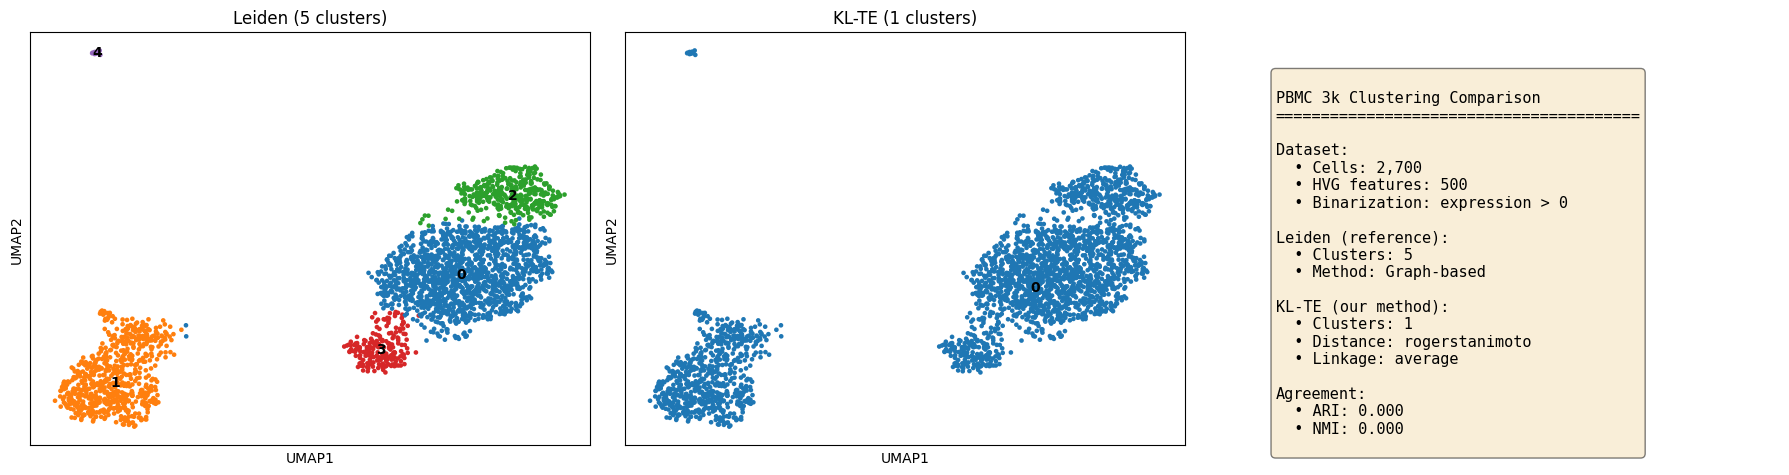


✓ UMAP visualization saved


In [ ]:
# Visualize: UMAP comparison

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Leiden clustering
sc.pl.umap(adata, color='leiden', ax=axes[0], show=False, 
           title=f'Leiden ({n_leiden_clusters} clusters)', legend_loc='on data')

# Plot 2: KL-TE clustering
sc.pl.umap(adata, color='kl_te', ax=axes[1], show=False,
           title=f'KL-TE ({result["num_clusters"]} clusters)', legend_loc='on data')

# Plot 3: Metrics summary
axes[2].axis('off')
summary_text = f"""
PBMC 3k Clustering Comparison
{'='*40}

Dataset:
  • Cells: {adata.n_obs:,}
  • HVG features: {n_hvg}
  • Binarization: expression > 0

Leiden (reference):
  • Clusters: {n_leiden_clusters}
  • Method: Graph-based

KL-TE (our method):
  • Clusters: {result['num_clusters']}
  • Distance: {config.TREE_DISTANCE_METRIC}
  • Linkage: {config.TREE_LINKAGE_METHOD}

Agreement:
  • ARI: {ari:.3f}
  • NMI: {nmi:.3f}
"""
axes[2].text(0.1, 0.9, summary_text, transform=axes[2].transAxes,
             fontsize=11, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../cluster_tree_plots/pbmc3k_clustering_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ UMAP visualization saved")

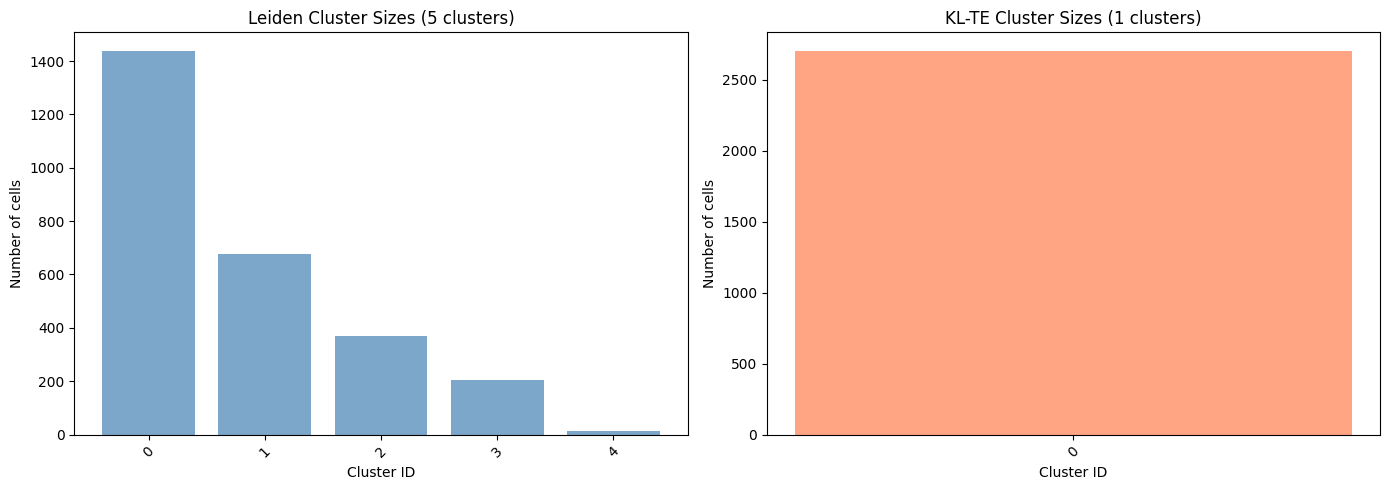


✓ Cluster size comparison saved


In [ ]:
# Visualize: Cluster size distribution

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Leiden cluster sizes
leiden_sizes = adata.obs['leiden'].value_counts().sort_index()
axes[0].bar(leiden_sizes.index.astype(str), leiden_sizes.values, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Cluster ID')
axes[0].set_ylabel('Number of cells')
axes[0].set_title(f'Leiden Cluster Sizes ({n_leiden_clusters} clusters)')
axes[0].tick_params(axis='x', rotation=45)

# KL-TE cluster sizes
kl_sizes = pd.Series(kl_labels).value_counts().sort_index()
axes[1].bar(kl_sizes.index.astype(str), kl_sizes.values, color='coral', alpha=0.7)
axes[1].set_xlabel('Cluster ID')
axes[1].set_ylabel('Number of cells')
axes[1].set_title(f'KL-TE Cluster Sizes ({result["num_clusters"]} clusters)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../cluster_tree_plots/pbmc3k_cluster_sizes.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Cluster size comparison saved")

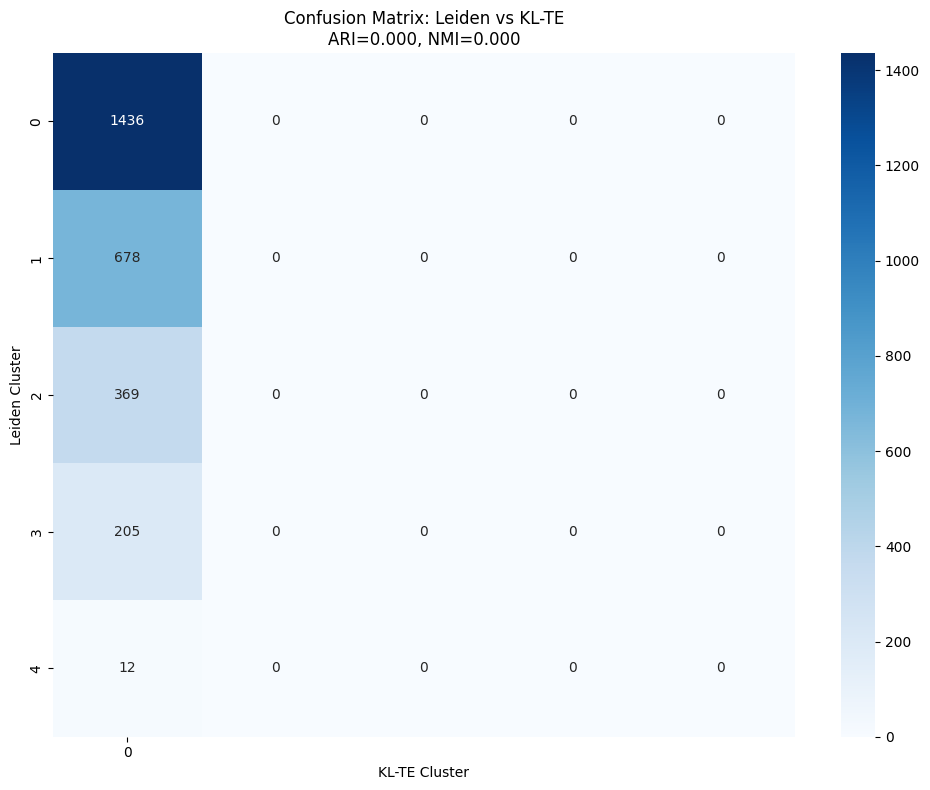


✓ Confusion matrix saved


In [ ]:
# Confusion matrix: Leiden vs KL-TE

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(leiden_labels, kl_labels)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=sorted(np.unique(kl_labels)),
            yticklabels=sorted(np.unique(leiden_labels)))
ax.set_xlabel('KL-TE Cluster')
ax.set_ylabel('Leiden Cluster')
ax.set_title(f'Confusion Matrix: Leiden vs KL-TE\nARI={ari:.3f}, NMI={nmi:.3f}')

plt.tight_layout()
plt.savefig('../cluster_tree_plots/pbmc3k_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrix saved")

Generating tree visualization...
  (This may take a moment for large datasets)


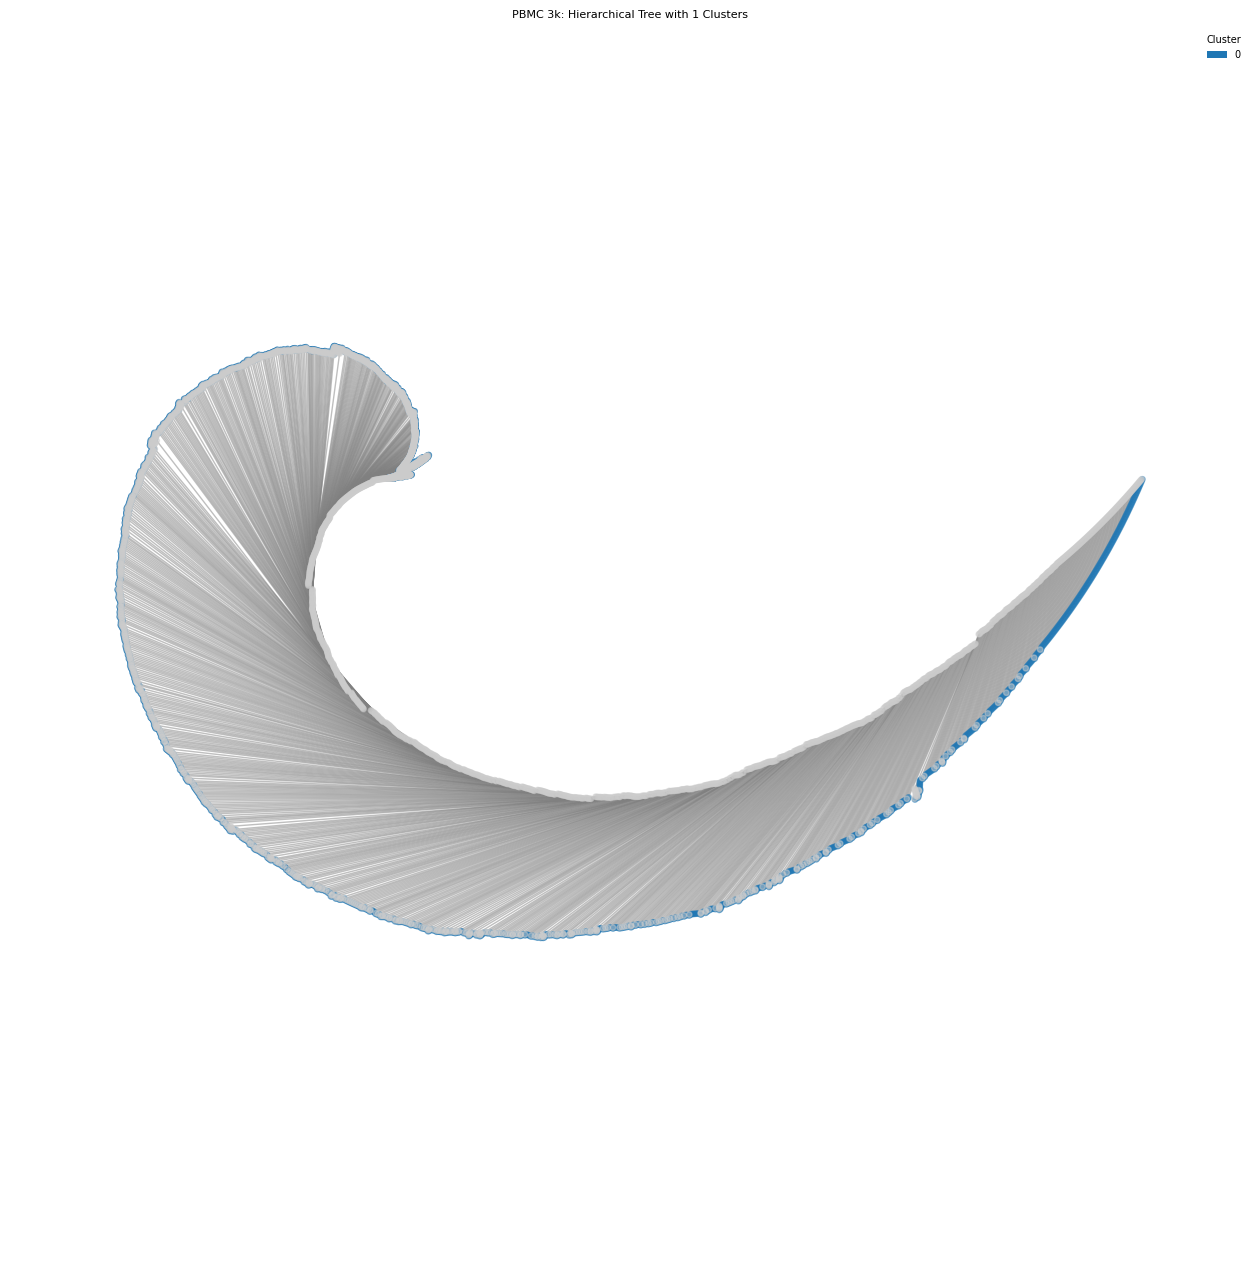


✓ Tree visualization saved


<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize: Hierarchical tree structure (subset for clarity)

print("Generating tree visualization...")
print("  (This may take a moment for large datasets)")

# Get stats dataframe
results_df = tree.stats_df

fig_tree, ax_tree = plot_tree_with_clusters(
    tree=tree,
    decomposition_results=result,
    results_df=results_df,
    figsize=(16, 16),
    node_size=15,
    font_size=8,
    title=f"PBMC 3k: Hierarchical Tree with {result['num_clusters']} Clusters",
    colormap='tab20',
    show=True
)

plt.savefig('../cluster_tree_plots/pbmc3k_tree_structure.png', dpi=150, bbox_inches='tight')
print("\n✓ Tree visualization saved")

In [ ]:
# Summary and save results

print("\n" + "="*60)
print("PBMC 3k CLUSTERING TEST - SUMMARY")
print("="*60)

print(f"""
Dataset:
  - Source: 10x Genomics PBMC 3k
  - Cells: {adata.n_obs:,}
  - Features (HVGs): {n_hvg}
  - Binarization: detected (>0) vs not detected

KL-TE Clustering:
  - Distance: {config.TREE_DISTANCE_METRIC}
  - Linkage: {config.TREE_LINKAGE_METHOD}
  - Clusters found: {result['num_clusters']}

Comparison with Leiden:
  - Leiden clusters: {n_leiden_clusters}
  - ARI: {ari:.3f}
  - NMI: {nmi:.3f}

Files saved:
  - ../cluster_tree_plots/pbmc3k_clustering_comparison.png
  - ../cluster_tree_plots/pbmc3k_cluster_sizes.png
  - ../cluster_tree_plots/pbmc3k_confusion_matrix.png
  - ../cluster_tree_plots/pbmc3k_tree_structure.png
""")

# Save results to CSV
current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_file = f"../results/pbmc3k_results_{current_date}.csv"

results_summary = pd.DataFrame({
    'cell_id': adata.obs_names,
    'leiden_cluster': leiden_labels,
    'kl_te_cluster': kl_labels
})
results_summary.to_csv(results_file, index=False)

print(f"✓ Results saved to: {results_file}")
print("\n" + "="*60)
print("TEST COMPLETE!")
print("="*60)


PBMC 3k CLUSTERING TEST - SUMMARY

Dataset:
  - Source: 10x Genomics PBMC 3k
  - Cells: 2,700
  - Features (HVGs): 500
  - Binarization: detected (>0) vs not detected

KL-TE Clustering:
  - Distance: rogerstanimoto
  - Linkage: average
  - Clusters found: 1

Comparison with Leiden:
  - Leiden clusters: 5
  - ARI: 0.000
  - NMI: 0.000

Files saved:
  - ../cluster_tree_plots/pbmc3k_clustering_comparison.png
  - ../cluster_tree_plots/pbmc3k_cluster_sizes.png
  - ../cluster_tree_plots/pbmc3k_confusion_matrix.png
  - ../cluster_tree_plots/pbmc3k_tree_structure.png

✓ Results saved to: ../results/pbmc3k_results_2025-12-19_20-05-51.csv

TEST COMPLETE!
